In [9]:
from collections import OrderedDict

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import ulmo

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#start date
st = "2018-10-01"
#end date
ed = "2019-09-29"

#Select state
state_name = 'Oregon'

#https://anthonylouisdagostino.com/bounding-boxes-for-all-us-states/
#bounding box
latmin = 46.292035
latmax = 41.991794
lonmin = -116.463504
lonmax = -124.566244

wa_bounds = (-124.566244, 41.991794, -116.463504, 46.292035)
# projection
to_crs = 'epsg:4326' #WGS84

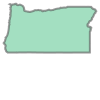

In [3]:
# projection
to_crs = 'epsg:4326' #WGS84

#State GDF
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()
states_gdf_proj = states_gdf.to_crs(to_crs)
state = states_gdf_proj.loc[states_gdf_proj['NAME'] == state_name]
geom = state.iloc[0].geometry
geom

In [4]:
geom.bounds

(-124.565973, 41.991794, -116.463504, 46.271004)

# Get SNOTEL data

In [5]:
def sites_asgdf(ulmo_getsites, crs=to_crs):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=crs
    )
    return sites_gdf

In [6]:
# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(geom.bounds[2],geom.bounds[1],geom.bounds[0],geom.bounds[3])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=to_crs)

In [7]:
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

# get dictionary of snotel sites 
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

#turn sites as geodataframe 
snotel_gdf = sites_asgdf(sites)


In [8]:
gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
gdf.drop(columns='index_right', inplace=True)
gdf.reset_index(drop=True, inplace=True)

gdf

,code,longitude,latitude,name,elevation_m,geometry
0,302_OR_SNTL,-117.192581,45.213280,Aneroid Lake #2,2255.52001953125,POINT (-117.19258 45.21328)
1,1000_OR_SNTL,-122.165176,42.870071,Annie Springs,1831.8480224609375,POINT (-122.16518 42.87007)
2,304_OR_SNTL,-119.253922,45.190849,Arbuckle Mtn,1758.696044921875,POINT (-119.25392 45.19085)
3,1166_OR_SNTL,-122.093803,44.325298,Bear Grass,1438.656005859375,POINT (-122.09380 44.32530)
4,324_ID_SNTL,-116.980972,44.605331,Bear Saddle,1883.6639404296875,POINT (-116.98097 44.60533)
...,...,...,...,...,...,...
108,821_OR_SNTL,-118.426170,44.655670,Tipton,1569.719970703125,POINT (-118.42617 44.65567)
109,1044_OR_SNTL,-122.425369,43.227180,Toketee Airstrip,987.552001953125,POINT (-122.42537 43.22718)
110,824_WA_SNTL,-117.850502,46.118679,Touchet,1685.5439453125,POINT (-117.85050 46.11868)
111,1007_OR_SNTL,-121.916672,45.433331,Usfs Nanny Creek,853.44000244140625,POINT (-121.91667 45.43333)


# Get HUC data

In [12]:
import requests
import xml.etree.ElementTree as ET

import warnings
warnings.filterwarnings('ignore')

In [13]:
def getHUC(lat, lon):
    """
    Function to get the HUC12 - HUC2 ids for a given latitude and longitude.
    Latitude and Longitude should be in WGS84 (EPSG:4326)
    """

    # the url of the web service for WBD info
    root='https://arcgis.cuahsi.org/arcgis/services/US_WBD/HUC_WBD/MapServer/WFSServer'

    # assumes that the input coords are in WGS84, i.e. EPSG:4326
    params = {'service': 'WFS',
              'request': 'GetFeature',
              'bbox': f"{lon}, {lat}, {lon}, {lat}",         
              'typeName': 'HUC_WBD:HUC12_US',
              'SrsName': 'EPSG:4326'}

    # make the WFS request
    r = requests.get(url = root, params = params, verify=False)
    
    # exit if we don't get a 200 response
    if r.status_code != 200:
        print(f'Error getting HUC for point: {lat}, {lon}')
        return None
    
    # load the response xml into memory
    root_xml =  ET.fromstring(r.text)
    
    # define xml namespaces to make parsing easier
    ns = {'xs': "http://www.w3.org/2001/XMLSchema",
          'wfs':"http://www.opengis.net/wfs/2.0",
          'gml':"http://www.opengis.net/gml/3.2",
          'US_WBD_HUC_WBD':"http://arcgis.cuahsi.org/arcgis/services/US_WBD/HUC_WBD/MapServer/WFSServer",
          'xlink':"http://www.w3.org/1999/xlink",
          'xsi': "http://www.w3.org/2001/XMLSchema-instance" 
         }
    
    # get the wfs:member element
    hucs = root_xml.findall('wfs:member', ns)
    
    # we should only get a single HUC since we're querying a point location
    huc12 = root_xml.findall('wfs:member/US_WBD_HUC_WBD:HUC12_US/US_WBD_HUC_WBD:HUC12', ns)[0].text
    
    return dict(huc12 = huc12,
                huc10 = huc12[:-2],
                huc8 = huc12[:-4],
                huc6 = huc12[:-6],
                huc4 = huc12[:-8],
                huc2 = huc12[:-10],
               )

In [70]:
h12 =[]
h10=[]
h8=[]
h6=[]
h4=[]
h2=[]
for i in gdf.index:
    try:
        hucs = getHUC(gdf.latitude[i],gdf.longitude[i])
        h12.append(hucs['huc12'])
        h10.append(hucs['huc10'])
        h8.append(hucs['huc8'])
        h6.append(hucs['huc6'])
        h4.append(hucs['huc4'])
        h2.append(hucs['huc2'])
    except:
        print(i,'error')
        gdf.drop([i], inplace=True)
    
gdf['huc12'] = h12
gdf['huc10'] = h10
gdf['huc8'] = h8
gdf['huc6'] = h6
gdf['huc4'] = h4
gdf['huc2'] = h2
gdf.reset_index(drop=True)

,code,longitude,latitude,name,elevation_m,geometry,huc12,huc10,huc8,huc6,huc4,huc2
0,302_OR_SNTL,-117.192581,45.213280,Aneroid Lake #2,2255.52001953125,POINT (-117.19258 45.21328),170601050101,1706010501,17060105,170601,1706,17
1,1000_OR_SNTL,-122.165176,42.870071,Annie Springs,1831.8480224609375,POINT (-122.16518 42.87007),180102030101,1801020301,18010203,180102,1801,18
2,304_OR_SNTL,-119.253922,45.190849,Arbuckle Mtn,1758.696044921875,POINT (-119.25392 45.19085),170702020604,1707020206,17070202,170702,1707,17
3,1166_OR_SNTL,-122.093803,44.325298,Bear Grass,1438.656005859375,POINT (-122.09380 44.32530),170900040203,1709000402,17090004,170900,1709,17
4,324_ID_SNTL,-116.980972,44.605331,Bear Saddle,1883.6639404296875,POINT (-116.98097 44.60533),170501241001,1705012410,17050124,170501,1705,17
...,...,...,...,...,...,...,...,...,...,...,...,...
107,821_OR_SNTL,-118.426170,44.655670,Tipton,1569.719970703125,POINT (-118.42617 44.65567),170502020101,1705020201,17050202,170502,1705,17
108,1044_OR_SNTL,-122.425369,43.227180,Toketee Airstrip,987.552001953125,POINT (-122.42537 43.22718),171003010404,1710030104,17100301,171003,1710,17
109,824_WA_SNTL,-117.850502,46.118679,Touchet,1685.5439453125,POINT (-117.85050 46.11868),170701020303,1707010203,17070102,170701,1707,17
110,1007_OR_SNTL,-121.916672,45.433331,Usfs Nanny Creek,853.44000244140625,POINT (-121.91667 45.43333),170800010501,1708000105,17080001,170800,1708,17


In [71]:
gdf.head()

,code,longitude,latitude,name,elevation_m,geometry,huc12,huc10,huc8,huc6,huc4,huc2
0,302_OR_SNTL,-117.192581,45.213280,Aneroid Lake #2,2255.52001953125,POINT (-117.19258 45.21328),170601050101,1706010501,17060105,170601,1706,17
1,1000_OR_SNTL,-122.165176,42.870071,Annie Springs,1831.8480224609375,POINT (-122.16518 42.87007),180102030101,1801020301,18010203,180102,1801,18
2,304_OR_SNTL,-119.253922,45.190849,Arbuckle Mtn,1758.696044921875,POINT (-119.25392 45.19085),170702020604,1707020206,17070202,170702,1707,17
3,1166_OR_SNTL,-122.093803,44.325298,Bear Grass,1438.656005859375,POINT (-122.09380 44.32530),170900040203,1709000402,17090004,170900,1709,17
4,324_ID_SNTL,-116.980972,44.605331,Bear Saddle,1883.6639404296875,POINT (-116.98097 44.60533),170501241001,1705012410,17050124,170501,1705,17


# Get DEM data

In [11]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

In [3]:
#Install the elevation package
!pip install elevation

     |████████████████████████████████| 71 kB 3.6 MB/s eta 0:00:011
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2


In [4]:
import elevation

In [14]:
#Set some variables for the SRTM download
cache_dir='./elevation'
#We'll use the 3-arcsec products 
product='SRTM3'
#Higher-res 1-arcsec products
#product='SRTM1'
output='or_%s_full.tif' % product

In [26]:
bounds = (-124.566244, 41.991794, -116.463504, 46.292035)
#elevation.clean(cache_dir=cache_dir)
elevation.seed(bounds=geom.bounds, cache_dir=cache_dir, product=product, max_download_tiles=999)
#elevation.clip(bounds=wa_bounds, output=output, cache_dir=cache_dir, product=product, max_download_tiles=999)

'./elevation/SRTM3'

In [15]:
#Check the downloaded products in the cache subdirectory
!ls -lh $cache_dir/$product/cache

total 102M
-rw-rw-r-- 1 jovyan users 25M Sep  3 02:18 srtm_12_03.tif
-rw-rw-r-- 1 jovyan users   0 Sep  3 02:17 srtm_12_03.tif.lock
-rw-rw-r-- 1 jovyan users 24M Sep  3 02:19 srtm_12_04.tif
-rw-rw-r-- 1 jovyan users   0 Sep  3 02:17 srtm_12_04.tif.lock
-rw-rw-r-- 1 jovyan users 29M Sep  3 02:20 srtm_13_03.tif
-rw-rw-r-- 1 jovyan users   0 Sep  3 02:17 srtm_13_03.tif.lock
-rw-rw-r-- 1 jovyan users 26M Sep  3 02:22 srtm_13_04.tif
-rw-rw-r-- 1 jovyan users   0 Sep  3 02:17 srtm_13_04.tif.lock


In [16]:
#Inspect the geotiff header
!gdalinfo $cache_dir/$product/cache/srtm_12_03.tif

Driver: GTiff/GeoTIFF
Files: ./elevation/SRTM3/cache/srtm_12_03.tif
Size is 6000, 6000
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-125.000000000000000,50.000000000000000)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-125.0000000,  50.0000000) (125d 0' 0.00"W, 50d 0' 0.00"N)
Lower Left  (-125.0000000,  45.0000000) (125d 0' 0.00"W, 4

In [17]:
# Create a vrt (virtual file) mosaic of the tif files¶
vrt_fn = '%s_wa_mosaic.vrt' % product
!gdalbuildvrt -r cubic $vrt_fn $cache_dir/$product/cache/*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [18]:
!cat $vrt_fn

<VRTDataset rasterXSize="12000" rasterYSize="12000">
  <SRS dataAxisToSRSAxisMapping="2,1">GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]</SRS>
  <GeoTransform> -1.2500000000000000e+02,  8.3333333333333339e-04,  0.0000000000000000e+00,  5.0000000000000000e+01,  0.0000000000000000e+00, -8.3333333333333339e-04</GeoTransform>
  <VRTRasterBand dataType="Int16" band="1">
    <NoDataValue>-32768</NoDataValue>
    <ColorInterp>Gray</ColorInterp>
    <ComplexSource resampling="cubic">
      <SourceFilename relativeToVRT="1">./elevation/SRTM3/cache/srtm_12_03.tif</SourceFilename>
      <SourceBand>1</SourceBand>
      <SourceProperties RasterXSize="6000" RasterYSize="6000" DataType="Int16" BlockXSize="256" BlockYSize="256" />
      <SrcRect xOff="0" yOff="0" xSize="60

In [19]:
#open the vrt with rasterio
src = rio.open(vrt_fn)

In [11]:
#review metadata
src.profile

{'driver': 'VRT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 12000, 'height': 12000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333333334, 0.0, -125.0,
       0.0, -0.0008333333333333334, 50.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}

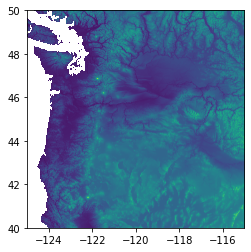

In [12]:
# plot
with rio.open(vrt_fn) as src:
    rio.plot.show(src)

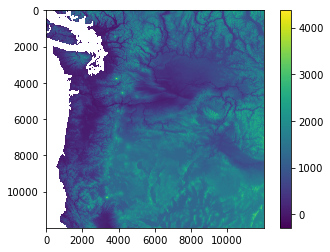

In [13]:
# Read the data and plot with matplotlib
with rio.open(vrt_fn) as src:
    f, ax = plt.subplots()
    srtm = np.ma.masked_equal(src.read(1), src.nodata)
    m = ax.imshow(srtm)
    plt.colorbar(m)

In [ ]:
#Sample DEM at points
#Return points that intersect OR state geometry
glas_gdf_utm_wa = glas_gdf_utm.loc[glas_gdf_utm.intersects(wa_geom)]

In [48]:
#build list of coordinates from point geodataframe
xy = list(map(list, zip(gdf.geometry.x,gdf.geometry.y)))

[[-117.19258117675781, 45.213279724121094],
 [-122.16517639160156, 42.87007141113281],
 [-119.25392150878906, 45.19084930419922],
 [-122.09380340576172, 44.32529830932617],
 [-116.98097229003906, 44.60533142089844],
 [-118.21900177001953, 45.145320892333984],
 [-122.85487365722656, 42.05257034301758],
 [-123.34393310546875, 42.07875061035156],
 [-122.26616668701172, 42.407169342041016],
 [-121.85604858398438, 45.4286994934082],
 [-118.51721954345703, 44.2476692199707],
 [-118.1878662109375, 44.83052062988281],
 [-118.46714782714844, 45.364280700683594],
 [-122.2163314819336, 45.903621673583984],
 [-122.06009674072266, 43.59041976928711],
 [-121.8066177368164, 43.22624969482422],
 [-121.75443267822266, 45.096580505371094],
 [-121.69159698486328, 45.18832015991211],
 [-122.17682647705078, 42.533050537109375],
 [-118.5501480102539, 45.191070556640625],
 [-120.94917297363281, 42.638099670410156],
 [-122.0871810913086, 44.52146911621094],
 [-119.93012237548828, 44.44649887084961],
 [-122.14

In [45]:
#sample dem
with rio.open(vrt_fn) as src:
    gdf['dem_elev'] = [sample[0] for sample in src.sample(coords)]

# DEM to slope and aspect

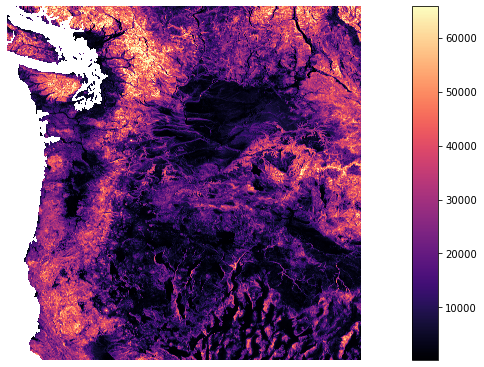

In [49]:
import richdem as rd
dem = rd.LoadGDAL(vrt_fn)

slope = rd.TerrainAttribute(dem, attrib='slope_riserun')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

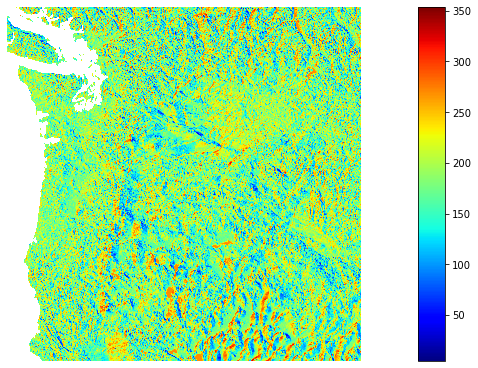

In [52]:
aspect = rd.TerrainAttribute(shasta_dem, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()

In [ ]:
#sample dem
with rio.open(vrt_fn) as src:
    gdf['slope'] = [sample[0] for sample in src.sample(coords)]

# Get time series data at stations

In [10]:
def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [11]:
stn_swe = pd.DataFrame(index=pd.date_range(start=st, end=ed))

for sitecode in CSO_gdf.code:
    try:
        swe = fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date=st, end_date=ed)
        stn_swe[sitecode] = swe.value
    except:
        print(sitecode, 'has no data')
        stn_swe[sitecode] = np.nan

302_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1000_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
304_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1166_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
324_ID_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
331_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
341_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
343_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
344_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
351_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
357_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
361_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
362_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1109_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
388_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
395_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
398_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
401_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
406_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
422_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1010_OR_SNTL SNOTEL:WTEQ_D 2018-10-01

Unable to fetch SNOTEL:WTEQ_D
1027_OR_SNTL has no data
1028_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1028_OR_SNTL has no data
1022_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1022_OR_SNTL has no data
1023_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1023_OR_SNTL has no data
1029_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1029_OR_SNTL has no data
1021_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1021_OR_SNTL has no data
1020_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1020_OR_SNTL has no data
1019_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1019_OR_SNTL has no data
1018_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1018_OR_SNTL has no data
1025_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1025_OR_SNTL has no data
1024_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
1024_OR_SNTL has no data
976_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
976_OR_SNTL has no data
477_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
479_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
483_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
945_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
494_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
504_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
523_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
526_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
529_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1158_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
259_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29


Unable to fetch SNOTEL:WTEQ_D
259_OR_SNTL has no data
1129_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
545_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
552_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
553_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
558_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
563_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
584_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
591_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
605_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
608_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
614_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
619_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1079_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1084_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
647_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
651_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
653_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
654_ID_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
655_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
660_OR_SNTL SNOTEL:WTEQ_D 2018-

Unable to fetch SNOTEL:WTEQ_D
263_WA_SNTL has no data
706_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
710_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
712_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
2029_ID_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
719_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
721_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
726_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
729_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
733_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1231_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
736_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
743_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
745_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
748_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
756_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
759_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
1167_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
767_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
985_WA_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
925_OR_SNTL SNOTEL:WTEQ_D 2018-

Unable to fetch SNOTEL:WTEQ_D
1007_OR_SNTL has no data
873_OR_SNTL SNOTEL:WTEQ_D 2018-10-01 2019-09-29
